In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import log_loss
import lightgbm as lgb
from datetime import datetime, timedelta

/kaggle/input/15th-data60sec/var_list.csv
/kaggle/input/15th-data60sec/train_label.csv
/kaggle/input/15th-data60sec/train_data.pickle/train_data.pickle
/kaggle/input/15th-data60sec/test_data.pickle/test_data.pickle


In [2]:
train = pd.read_pickle('/kaggle/input/15th-data60sec/train_data.pickle/train_data.pickle')
test = pd.read_pickle('/kaggle/input/15th-data60sec/test_data.pickle/test_data.pickle')
train_label = train['label']

var_list = list(pd.read_csv('/kaggle/input/15th-data60sec/var_list.csv')['var'])

In [3]:
var_list = list(reversed(sorted(list(set(var_list) - set(train.columns[train.isna().any()].tolist() + test.columns[test.isna().any()].tolist())))))

train = train.loc[(train['time'] >= 10),var_list].reset_index(drop=True)
test = test.loc[(test['time'] >= 10),list(set(var_list) - set(['label']))].reset_index(drop=True)

In [4]:
all = pd.concat([train,test],axis=0)
all_value_cnt = all.nunique()

In [5]:
cat_var = list(all_value_cnt[(all_value_cnt < 11) & (all_value_cnt > 2)].index)
bin_var = list(all_value_cnt[all_value_cnt == 2].index)
num_var = list(set(var_list) - set(cat_var) - set(bin_var) - set(['label','id','time']))
etc_var = ['label','id','time']

In [6]:
import_var = ['V3616','V0081','V3324','V3615','V2855','V2859','V1821','V1818','V3098',
 'V3461','V4505','V1820','V2861','V2860','V1819','V3432','V2586','V2854',
 'V4743','V4824','V3103','V2853','V4495','V2076','V4525']

In [7]:
cat_lbl = pd.DataFrame()
for a in (bin_var + cat_var):
    cat_lbl[a] = pd.factorize(all[a])[0]

dup_cols = {}
for i, c1 in enumerate(tqdm(cat_lbl.columns)):
    for c2 in cat_lbl.columns[i+1:]:
        if c2 not in dup_cols and np.all(cat_lbl[c1] == cat_lbl[c2]):
            dup_cols[c2] = c1

cat_lbl.drop(dup_cols.keys(), axis = 1, inplace = True)
cat_lbl.shape

100%|██████████| 335/335 [00:30<00:00, 11.02it/s]


(77400, 261)

In [8]:
num = cat_lbl.nunique()
cat_var = list(num[num > 2].index)
bin_var = list(num[num == 2].index)

var_type_list = pd.DataFrame({'var' : etc_var + cat_var + bin_var + num_var,
              'type' : np.concatenate([np.repeat(['etc'],3),
                                       np.repeat(['cat'],len(cat_var)),
                                       np.repeat(['bin'],len(bin_var)),
                                       np.repeat(['num'],len(num_var))])})

grp_var = list(var_type_list[var_type_list['type'] == 'cat']['var']);grp_var[:5]

all = all[etc_var + num_var + cat_var + bin_var]

In [9]:
concat_var = [['V0050','V0051'],['V0469','V0471','V0472'],['V0529','V0530','V0532'],['V0731','V0733','V0735'],['V4502','V4504'],['V4526','V4527']]

for a in tqdm(concat_var):
    
    colnm = '_'.join(a + ['concat'])
    temp = pd.Series(np.repeat('',len(all)))
    
    for col in a:
        temp2 = all[col].astype(str)
        temp = temp.str.cat(temp2)
        
        all[colnm] = pd.factorize(temp)[0]

100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


In [10]:
for col in tqdm(cat_var + [a for a in all.columns if 'concat' in a]):
    temp = all.groupby(col)['id'].count().to_dict()
    all[col+'_freq'] = all[col].map(temp)
    del temp

100%|██████████| 44/44 [00:00<00:00, 61.41it/s]


In [11]:
all.shape

(77400, 2521)

In [12]:
for i,col1 in enumerate(import_var[:5]):
    for i2 in range(i+1,5):
        all[col1+'*'+import_var[:5][i2]] = all[col1] * all[import_var[:5][i2]]
        all[col1+'/'+import_var[:5][i2]] = all[col1] / all[import_var[:5][i2]]
        all[col1+'+'+import_var[:5][i2]] = all[col1] + all[import_var[:5][i2]]
        all[col1+'-'+import_var[:5][i2]] = all[col1] - all[import_var[:5][i2]]

In [13]:
train = all[~all['label'].isnull()].reset_index(drop=True).drop(columns = ['time'])
test = all[all['label'].isnull()].reset_index(drop=True).drop(columns = ['time','label'])

del all

In [14]:
%%time

train = train.groupby('id').rolling(window = 5).mean().drop(columns = ['id']).reset_index().drop(columns = ['level_1']).dropna().reset_index(drop=True)
train_label = train['label']
train_id = train['id']

test = test.groupby('id').rolling(window = 5).mean().drop(columns = ['id']).reset_index().drop(columns = ['level_1']).dropna().reset_index(drop=True)
test_id = test['id']

var_model = list(set(train.columns) & set(test.columns) - set(['id']))

CPU times: user 1min 40s, sys: 1.28 s, total: 1min 42s
Wall time: 1min 42s


In [15]:
def tr_vl_split(train_df, num, seed):    
    '''
    train / validation split 함수
    train 에 모든 label이 최소 한번은 등장 & train과 validation의 id는 겹치지 않도록 split함.
    
    train_df : train 데이터
    num : label 당 몇개의 id를 뽑을 것이냐.
    seed = random seed
    
    '''
    
    np.random.seed(seed)
    
    valid_id = []
    vc = train[['id','label']].drop_duplicates()['label'].value_counts()
    temp = list(vc[vc > num].index)
    for a in temp:
        id_list = list(train_df[train_df['label'] == a]['id'])
        valid_id += random.sample(id_list,num)
    
    train_id = list(set(train_df['id']) - set(valid_id))
    
    x_tr_ = train[train['id'].isin(train_id)]
    y_tr_ = train_label[train['id'].isin(train_id)]

    x_vl_ = train[~train['id'].isin(train_id)]
    y_vl_ = train_label[~train['id'].isin(train_id)]
    
    return x_tr_, y_tr_, x_vl_, y_vl_ 

In [16]:
x_tr, y_tr, x_vl, y_vl = tr_vl_split(train, 2, seed = 1995)

print('train shape :',x_tr.shape)
print('validation shape :',x_vl.shape)
print('test shape :', test.shape)

train shape : (30498, 2560)
validation shape : (7590, 2560)
test shape : (33120, 2559)


In [17]:
%%time

lgb_tr = lgb.Dataset(x_tr[var_model], label=y_tr)
lgb_vl = lgb.Dataset(x_vl[var_model], label=y_vl)

watchlist_1 = [lgb_tr, lgb_vl]
watchlist_2 = [lgb_vl, lgb_tr]

params = {
    "objective": "multiclass",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "multiclass",
    "num_class" : 198
}

lgb_model = lgb.train(params, train_set=lgb_tr, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=100, early_stopping_rounds=100)

prediction = pd.DataFrame(lgb_model.predict(test[var_model]))

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.0239823	valid_1's multi_logloss: 1.08824
[200]	training's multi_logloss: 0.00271781	valid_1's multi_logloss: 1.01384
[300]	training's multi_logloss: 0.00119244	valid_1's multi_logloss: 1.00398
[400]	training's multi_logloss: 0.000750227	valid_1's multi_logloss: 1.00147
[500]	training's multi_logloss: 0.0005452	valid_1's multi_logloss: 1.00137
Early stopping, best iteration is:
[449]	training's multi_logloss: 0.000633694	valid_1's multi_logloss: 1.00107
CPU times: user 12h 27min 33s, sys: 57.8 s, total: 12h 28min 31s
Wall time: 3h 11min 48s


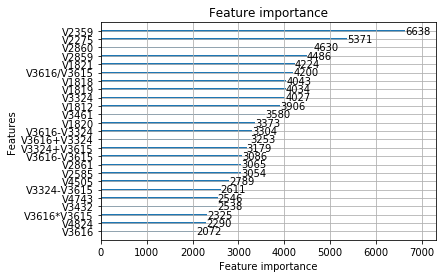

In [18]:
lgb.plot_importance(lgb_model,max_num_features = 25)

In [19]:
time_now = datetime.now() + timedelta(hours = 9)
submission_name = str(time_now)[:16] + '_submission.csv'
sub = pd.concat([pd.DataFrame(test_id),prediction],axis=1).groupby('id').mean().reset_index()
sub.to_csv(submission_name,index=False)